In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import optuna
import os
import math
import matplotlib.pyplot as plt
import random

In [2]:
seed = 42 
torch.manual_seed(seed)


torch.cuda.manual_seed_all(seed)


torch.backends.cudnn.deterministic = True


np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random.seed(seed)

In [3]:
transform = transforms.Compose([
  #  transforms.Resize((224, 224)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  
  #  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

data_dir = "./data/olivetti2/" 
dataset = datasets.ImageFolder(data_dir, transform=transform)

total_size = len(dataset)
train_size = int(0.8 * total_size)  
test_size = total_size - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [4]:
len(test_dataset)

800

In [5]:
class Raylu(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) 

    def forward(self, input):
        x = torch.where(input>=0, input, input*torch.exp(-input**2/self.sigma**2/2))
        return x

In [5]:
class Pgelu(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) 

    def forward(self, input):
    #    sigma = trial.suggest_float('sigma1',0,10)
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2

In [6]:
class Exlu(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) 

    def forward(self, input):
        temp1=torch.max(torch.zeros_like(input), input)
        temp2=torch.min(torch.zeros_like(input), input*torch.exp(input / self.sigma))
        
        return temp1+temp2

In [7]:
class sigmaSwish(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) 

    def forward(self, input):
        temp1=input * torch.sigmoid(input / self.sigma)
        
        return temp1

In [8]:
class myELU(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) 

    def forward(self, input):
        temp1=torch.max(torch.zeros_like(input), input)
        temp2=torch.min(torch.zeros_like(input), (torch.exp(input) - 1) / self.sigma)
        return temp1+temp2

In [6]:
class Encoder(nn.Module):
    def __init__(self, trial):
        super(Encoder, self).__init__()
   #     self.flatten = nn.Flatten() 
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.func1 = Raylu(1, trial)
        self.func2 = Raylu(2, trial)
        self.func3 = Raylu(3, trial)
        self.func4 = Raylu(4, trial)
        
        self.flatten = nn.Flatten(start_dim=1)
        self.line1 = nn.Linear(8 * 8 * 64, 256)
        self.line2 = nn.Linear(256, 30)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.func1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.func2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.func3(x)
        
        x = self.flatten(x)
        
        x = self.line1(x)
        x = x = self.func4(x)
        x = self.line2(x)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, trial):
        super(Decoder, self).__init__()
        self.line1 = nn.Linear(30, 256)
        self.line2 = nn.Linear(256, 8 * 8 * 64)
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 8, 8))
        
        self.func5 = Raylu(5, trial)
        self.func6 = Raylu(6, trial)
        self.func7 = Raylu(7, trial)
        self.func8 = Raylu(8, trial)
        
        self.convT1 = nn.ConvTranspose2d(64, 32, 3, stride=2,padding=1, output_padding=1)
        self.convT2 = nn.ConvTranspose2d(32, 16, 3, stride=2,padding=1, output_padding=1)
        self.convT3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)
        
        
    def forward(self, x):
        x = self.line1(x)
        x = self.func5(x)
        x = self.line2(x)
        x = self.func6(x)
        
        x = self.unflatten(x)
        
        x = self.convT1(x)
        x = self.bn1(x)
        x = self.func7(x)
        x = self.convT2(x)
        x = self.bn2(x)
        x = self.func8(x)
        x = self.convT3(x)
        
        x = torch.sigmoid(x)
        
        return x

In [13]:
# Set random seed for PyTorch
seed = 0  # You can use any integer as the seed
torch.manual_seed(seed)


torch.cuda.manual_seed_all(seed)


torch.backends.cudnn.deterministic = True


np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random.seed(seed)

In [14]:
def objective(trial):

    # Generate the model.
 #   bottleNeck = 10

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder = Encoder(trial).to(device)
    decoder = Decoder(trial).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

    EPOCHS = 100

     
    for epoch in range(EPOCHS):
        encoder.train()
        decoder.train()
        train_loss = 0.0

        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)

      
            optimizer.zero_grad()

      
            encoded = encoder(inputs)
            outputs = decoder(encoded)

       
            loss = criterion(outputs, inputs)

    
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        
        
       
        encoder.eval()
        decoder.eval()
        test_loss = 0.0
  #      global test_loss_save

        with torch.no_grad():
            for data in test_loader:
                inputs, _ = data
                inputs = inputs.to(device)

                # Forward pass
                encoded = encoder(inputs)
                outputs = decoder(encoded)

                # Compute the loss
                loss = criterion(outputs, inputs)

                test_loss += loss.item() * inputs.size(0)
    
        testLossTemp = test_loss / len(test_loader.dataset)
    #    test_loss_save.append(testLossTemp)

        trial.report(testLossTemp, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return testLossTemp

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('TestLoss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-15 22:00:18,983] A new study created in memory with name: no-name-3bd2bba9-0e54-4f5b-9eef-bb08ecf57927
[I 2023-12-15 22:05:06,991] Trial 0 finished with value: 0.002892269231379032 and parameters: {'$\\sigma_1$': 1.9674637815020612, '$\\sigma_2$': 0.6676305376583513, '$\\sigma_3$': 1.3789817442393837, '$\\sigma_4$': 5.569757169324358, '$\\sigma_5$': 6.213179804115124, '$\\sigma_6$': 8.697931938935486, '$\\sigma_7$': 5.757243664676884, '$\\sigma_8$': 0.05845339583339104}. Best is trial 0 with value: 0.002892269231379032.
[I 2023-12-15 22:10:35,655] Trial 1 finished with value: 0.0031383545696735383 and parameters: {'$\\sigma_1$': 3.029905492512055, '$\\sigma_2$': 5.940730462232663, '$\\sigma_3$': 1.4914330898936912, '$\\sigma_4$': 0.8967699842969523, '$\\sigma_5$': 8.52705124779903, '$\\sigma_6$': 2.5308841298501097, '$\\sigma_7$': 5.94968648919164, '$\\sigma_8$': 9.301811722258456}. Best is trial 0 with value: 0.002892269231379032.
[I 2023-12-15 22:16:00,445] Trial 2 finishe

TestLoss: 0.002892269231379032
Best hyperparameters: {'$\\sigma_1$': 1.9674637815020612, '$\\sigma_2$': 0.6676305376583513, '$\\sigma_3$': 1.3789817442393837, '$\\sigma_4$': 5.569757169324358, '$\\sigma_5$': 6.213179804115124, '$\\sigma_6$': 8.697931938935486, '$\\sigma_7$': 5.757243664676884, '$\\sigma_8$': 0.05845339583339104}


In [16]:
import joblib
joblib.dump(study, "studyOliRaylu.pkl")

['studyOliRaylu.pkl']

In [13]:
import joblib
study = optuna.create_study(direction='minimize')

study = joblib.load("studyOliRaylu.pkl")

trial = study.best_trial
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2023-12-10 18:24:22,719] A new study created in memory with name: no-name-6451a550-de93-4885-bd5d-f5d5db855a0f


Best trial until now:
 Value:  0.0027644899487495422
 Params: 
    $\sigma_1$: 1.176482387324428
    $\sigma_2$: 0.6386994048511729
    $\sigma_3$: 2.067367370483998
    $\sigma_4$: 7.146447673167562
    $\sigma_5$: 5.391058327193312
    $\sigma_6$: 5.6204813988995745
    $\sigma_7$: 3.9031064867300103
    $\sigma_8$: 0.6459768232394092


In [12]:
print(10 * np.log10(1 / study.best_trial.value))

25.204706454550433


In [29]:
import pandas as pd
frame1 = pd.DataFrame(study.trials_dataframe())
frame1.to_csv('./optunaOliRaylu.csv', index=False)

In [15]:
fig = optuna.visualization.plot_contour(study, params=["$\sigma_1$", "$\sigma_2$"]) 
fig.update_layout(title='',xaxis_title='$\sigma_1$',yaxis_title='$\sigma_2$')
fig['data'][0]['colorbar']['title']['text']='Reconstruction error'
fig.show()

In [5]:
class Pgelu2(nn.Module): 
    def __init__(self, sigma=1.0):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2

In [19]:
class Encoder2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
      #  self.func = nn.ReLU(True)
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            Pgelu2(1.176482387324428),
            # Second convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            Pgelu2(0.6386994048511729),
            # Third convolutional layer
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            Pgelu2(2.067367370483998)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)        

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(8 * 8 * 64, 256),
            Pgelu2(7.146447673167562),
            # Second linear layer
            nn.Linear(256, 30)
        )
        
    def forward(self, x):
        # Apply convolutions

        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [20]:
class Decoder2(nn.Module):
    
    def __init__(self):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(30, 256),
            Pgelu2(5.391058327193312),
            # Second linear layer
            nn.Linear(256, 8 * 8 * 64),
            Pgelu2(5.6204813988995745)
        )
        
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 8, 8))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(64, 32, 3, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            Pgelu2(3.9031064867300103),
            
            nn.ConvTranspose2d(32, 16, 3, stride=2,padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            Pgelu2(0.6459768232394092),
           
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [21]:
seed = 0  
torch.manual_seed(seed)


torch.cuda.manual_seed_all(seed)


torch.backends.cudnn.deterministic = True


np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random.seed(seed)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder2().to(device)
decoder = Decoder2().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

epochs = 100

In [22]:

def train(encoder, decoder, train_loader, criterion, optimizer, device):
    encoder.train()
    decoder.train()
    train_loss = 0.0

    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

      
        optimizer.zero_grad()

      
        encoded = encoder(inputs)
        outputs = decoder(encoded)

       
        loss = criterion(outputs, inputs)

    
        loss.backward()
        optimizer.step()
        
        
        
        
        

        train_loss += loss.item() * inputs.size(0)
        

    return train_loss / len(train_loader.dataset)

def test(encoder, decoder, test_loader, criterion, device):
    encoder.eval()
    decoder.eval()
    test_loss = 0.0
    global lowest_test_loss
    global epochBest
    global test_loss_save

    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            
            inputs = inputs.to(device)

            # Forward pass
            encoded = encoder(inputs)
            outputs = decoder(encoded)

            # Compute the loss
            loss = criterion(outputs, inputs)

            test_loss += loss.item() * inputs.size(0)
            
    
    
    testLossTemp = test_loss / len(test_loader.dataset)
    
    if testLossTemp < lowest_test_loss and epoch>10:
        lowest_test_loss = testLossTemp
        # Save the model's parameters to a .pt file
        torch.save(encoder.state_dict(), 'CONVencoderOpPgelu.pt')
        torch.save(decoder.state_dict(), 'CONVdecoderOpPgelu.pt')
        epochBest = epoch
        print(f'Epoch {epochBest}, testLoss update to {lowest_test_loss:.4f}!')
    
    
    test_loss_save.append(testLossTemp)
    return testLossTemp

In [19]:
test_loss_save = []
lowest_test_loss = float('inf')
epochBest = 0



for epoch in range(epochs):
    train_loss = train(encoder, decoder, train_loader, criterion, optimizer, device)
    test_loss = test(encoder, decoder, test_loader, criterion, device)
    test_PSNR = 10 * np.log10(1 / test_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}，Test PSNR: {test_PSNR:.4f}")
    
encoder.load_state_dict(torch.load('CONVencoderOpPgelu.pt'))
decoder.load_state_dict(torch.load('CONVdecoderOpPgelu.pt'))

Epoch 1/100, Train Loss: 0.0145, Test Loss: 0.0072，Test PSNR: 21.4039
Epoch 2/100, Train Loss: 0.0063, Test Loss: 0.0053，Test PSNR: 22.7707
Epoch 3/100, Train Loss: 0.0050, Test Loss: 0.0046，Test PSNR: 23.3667
Epoch 4/100, Train Loss: 0.0046, Test Loss: 0.0044，Test PSNR: 23.5947
Epoch 5/100, Train Loss: 0.0043, Test Loss: 0.0042，Test PSNR: 23.8030
Epoch 6/100, Train Loss: 0.0041, Test Loss: 0.0040，Test PSNR: 24.0080
Epoch 7/100, Train Loss: 0.0039, Test Loss: 0.0038，Test PSNR: 24.1715
Epoch 8/100, Train Loss: 0.0037, Test Loss: 0.0038，Test PSNR: 24.2546
Epoch 9/100, Train Loss: 0.0035, Test Loss: 0.0036，Test PSNR: 24.4144
Epoch 10/100, Train Loss: 0.0034, Test Loss: 0.0035，Test PSNR: 24.5284
Epoch 11/100, Train Loss: 0.0032, Test Loss: 0.0034，Test PSNR: 24.6400
Epoch 11, testLoss update to 0.0033!
Epoch 12/100, Train Loss: 0.0031, Test Loss: 0.0033，Test PSNR: 24.8245
Epoch 12, testLoss update to 0.0032!
Epoch 13/100, Train Loss: 0.0029, Test Loss: 0.0032，Test PSNR: 24.9257
Epoch 13, te

<All keys matched successfully>

In [23]:
encoder.load_state_dict(torch.load('CONVencoderOpPgelu.pt'))
decoder.load_state_dict(torch.load('CONVdecoderOpPgelu.pt'))

<All keys matched successfully>

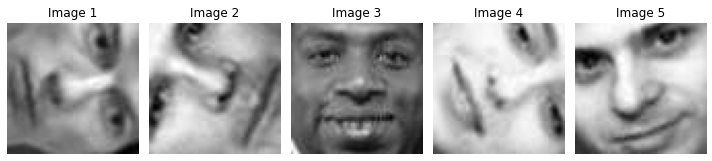

In [24]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF  


start_index = 0  
end_index = 5  

indexs = range(start_index, end_index)


selected_images = []

for idx in indexs:
    
    image, label = test_dataset[idx]

    
    image = TF.to_pil_image(image)  

    
    selected_images.append(image)


plt.figure(figsize=(10, 5))
for i in range(len(selected_images)):
    plt.subplot(1, len(selected_images), i + 1)
    plt.imshow(selected_images[i], cmap='gray') 
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:

reconstructed_images1 = []


encoder.eval()
decoder.eval()


transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

with torch.no_grad():
    for image in selected_images:
        
        image_tensor = transform2(image).unsqueeze(dim=0)  
        image_tensor = image_tensor.to(device)

        
        reconstructed_image = decoder(encoder(image_tensor))
        reconstructed_pil_image = TF.to_pil_image(reconstructed_image.squeeze().cpu())

        
        reconstructed_images1.append(reconstructed_pil_image)

D:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.


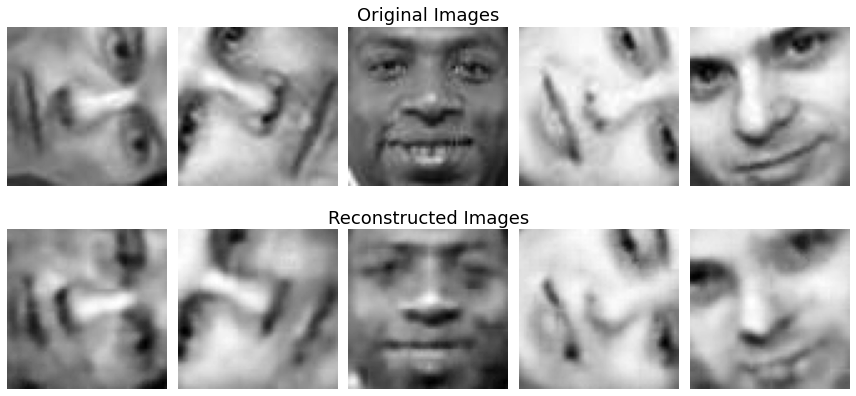

In [26]:

fig, axs = plt.subplots(2, 5, figsize=(12, 6))



for i in range(5):
    axs[0, i].imshow(selected_images[i], cmap='gray')
    axs[0, i].axis('off')


for i in range(5):
    axs[1, i].imshow(reconstructed_images1[i], cmap='gray')
    axs[1, i].axis('off')


axs[0, 2].set_title('Original Images', fontsize=18)
axs[1, 2].set_title('Reconstructed Images', fontsize=18)



plt.tight_layout()
plt.savefig('output_imageOptunaPgelu.jpg', dpi=150, quality=95)  
plt.show()

In [49]:
lowest_test_loss

0.0026903284154832364